# $-4 \leq \eta \leq -2.5$  

In this notebook, for run **291694**, we plot the MC data with and without the selection condition $-4 \leq \eta \leq -2.5$. 


In [18]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc

from Plot import Plot

In [19]:
vector.register_awkward() 

In [20]:
DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [21]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [22]:
SAMPLE_RUNS=[291694,291399]

In [23]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
events = file["eventsTree"]
events.show()

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'mc'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | st

In [24]:
events.num_entries

40000

In [25]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "DCAx":events["Muon_xDCA"],
                       "DCAy":events["Muon_yDCA"],
                       "DCAz":events["Muon_zDCA"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [26]:
def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hpDCA:hist.Hist, hsigmapDCA:hist.Hist, hfraction:hist.Hist, hpt:hist.Hist, heta:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_xDCA","Muon_yDCA","Muon_zDCA","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(goodEvents)
        goodTracks=tracks[trackSelector(tracks)]

        #_______________computing pDCA
        DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
        p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
        pDCA=p0*DCA
        #print("pDCA minimum value is : ", ak.min(pDCA) , " and pDCA maximum value is : ", ak.max(pDCA))

        ##_______________computing pDCA resolution to define the cut 
        #momentum resolution for pDCA 
        N=1 #choice of resolution should be a number between 1 and 10
        sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
        pRes= 0.0004 * goodTracks.p
        sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))


        #angular resolution for pDCA
        thetaRes= 0.0005 * goodTracks.p
        sigmatheta= 535 * thetaRes

        #computing total resolution for pDCA
        sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

        ##_______________fraction pDCA/sigmapDCA to choose the N value
        fraction=pDCA/sigmapDCA

        hpt.fill(ak.flatten(goodTracks.pt))
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi))
        hpDCA.fill(ak.flatten(pDCA))
        hsigmapDCA.fill(ak.flatten(sigmapDCA))
        hfraction.fill(ak.flatten(fraction))
        heta.fill(ak.flatten(goodTracks.eta))
        
        if verbose:
            print(batch[1])
        gc.collect()
       


In [35]:
%%time
## SINGLE MUON TRACK PLOTS
#_____total_momentum
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))

#_____azimutal angle
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))

#pt selection
vhptRaw = hist.Hist(hist.axis.Regular(bins=1000,start=0,stop=15,name='$p_T$'))
vhptEvSel = hist.Hist(hist.axis.Regular(bins=1000,start=0,stop=15,name='$p_T$'))

#eta selection
vhetaRaw = hist.Hist(hist.axis.Regular(bins=100,start=-5,stop=-3.5,name=r'$\eta$'))
vhetaEvSel = hist.Hist(hist.axis.Regular(bins=100,start=-5,stop=-3.5,name=r'$\eta$'))

#_____pDCA
vhpDCAEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=2500,name='pDCA'))
vhpDCARaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=2500,name='pDCA'))

#_____sigma_pDCA
vhsigmapDCAEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=300,name=r'$\sigma_{pDCA}$'))
vhsigmapDCARaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=100,name=r'$\sigma_{pDCA}$'))

#_____fraction_for pDCA
vhfractionEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=10,name=r'pDCA/$\sigma_{pDCA}$'))
vhfractionRaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=10,name=r'pDCA/$\sigma_{pDCA}$'))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ scan the data  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hpDCA=vhpDCARaw, hsigmapDCA=vhsigmapDCARaw, hfraction=vhfractionRaw, hpt=vhptRaw, heta=vhetaRaw)

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hpDCA=vhpDCAEvSel, hsigmapDCA=vhsigmapDCAEvSel, hfraction=vhfractionEvSel, hpt=vhptEvSel, heta=vhetaEvSel,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4.0))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Please write the cuts made ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
EventsCut= "no cuts" 
TracksCut =r"-4 < $\eta$ <-2.5"

CPU times: user 850 ms, sys: 25 ms, total: 875 ms
Wall time: 906 ms


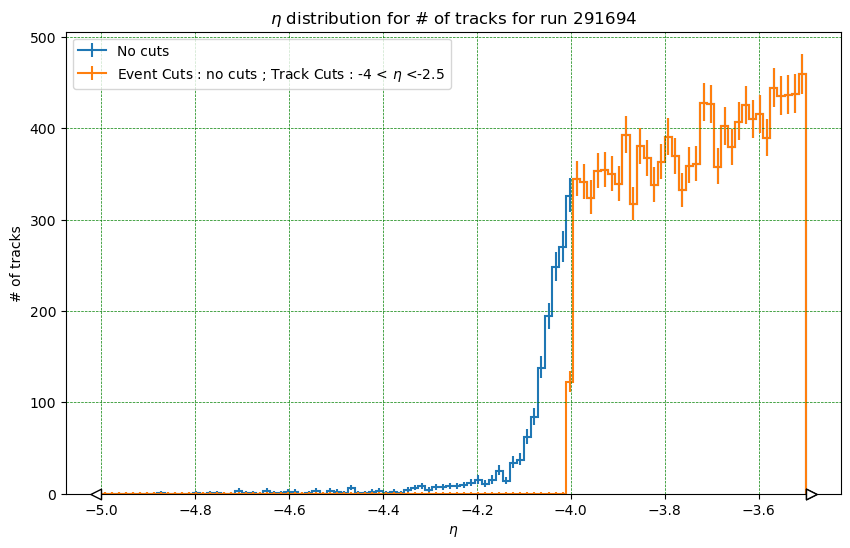

In [36]:
Plot(vhetaRaw, vhetaEvSel, "No cuts",  "Event Cuts : "+ EventsCut + " ; Track Cuts : " + TracksCut,
     r"$\eta$", title=r"$\eta$ distribution for # of tracks for run 291694", 
     save=True, savename='eta_291694')

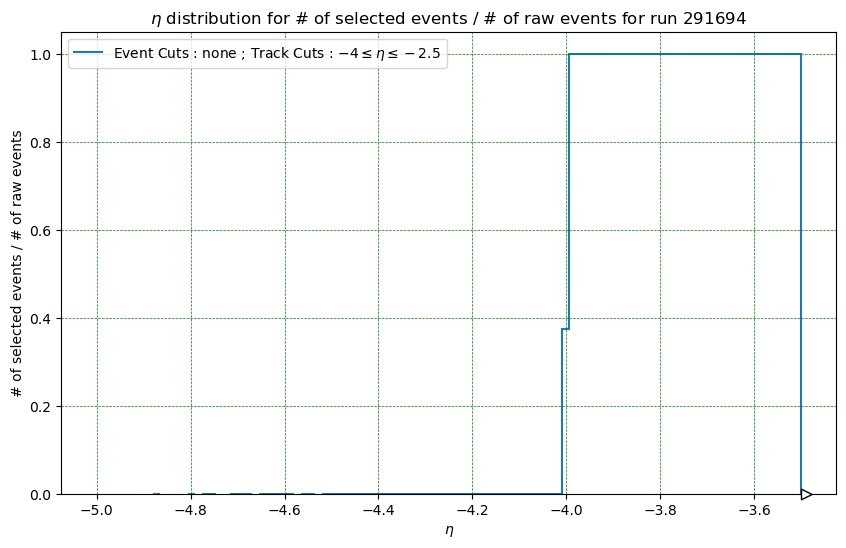

In [39]:
Plot(vhetaEvSel, vhetaRaw, 
     labelH1=r"Event Cuts : none ; Track Cuts : $-4 \leq \eta \leq -2.5$ ",
     labelx=r"$\eta$", labely="# of selected events / # of raw events",  
     title=r"$\eta$ distribution for # of selected events / # of raw events for run 291694", 
     ratio =True, save=True, savename= 'ratio_eta_291694')